# E-commerce recommender system

We are building a recommender system for an e-commerce site mainly selling clothing.

Here are the details about the products we know:
- price
- the number of reviewers
- their rating
- textual description
- name of the product (usually contains the brand name)
- category
    
We have two users, and each of them can be either be characterised by
- the initial choice of a product offered to them at registration.
- or more general characteristics explained in the below paragraph (price, reviews)
   
Users have preferences on the textual characteristics of products (description, name, category), and according to classical economics, ceteris paribus prefers products 
- that cost less
- has a lot of reviews
- with higher ratings
so we are going to set our spaces up to reflect that.

In the second part of the notebook, we introduce behavioural data in the form of events and their effects. 

Let's imagine we first examine a cold-start setup - we try to recommend items for users we know very little of. 

After introducing user behavioural data in the form of events, we look at users with some history on our site: clicked on products, bought others, etc. These are taken into account to improve the quality of the recommendations.

## Boilerplate

Let's set ourselves up to do something great.

### Installation

In [1]:
%pip install superlinked==3.34.1

### Imports and constants

In [2]:
import altair as alt
import os
import pandas as pd
import sys

from superlinked.framework.common.embedding.number_embedding import Mode
from superlinked.framework.common.schema.schema import schema
from superlinked.framework.common.schema.event_schema import event_schema
from superlinked.framework.common.schema.schema_object import String, Integer
from superlinked.framework.common.schema.schema_reference import SchemaReference
from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.common.parser.dataframe_parser import DataFrameParser
from superlinked.framework.dsl.executor.in_memory.in_memory_executor import (
    InMemoryExecutor,
    InMemoryApp,
)
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.index.effect import Effect
from superlinked.framework.dsl.query.param import Param
from superlinked.framework.dsl.query.query import Query
from superlinked.framework.dsl.query.result import Result
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.space.text_similarity_space import TextSimilaritySpace
from superlinked.framework.dsl.space.number_space import NumberSpace

alt.renderers.enable("mimetype")
pd.set_option("display.max_colwidth", 190)

In [3]:
TOP_N = 10
PRODUCT_DATASET_URL = "https://storage.googleapis.com/superlinked-notebook-e-commerce-dataset/e_commerce_notebook_recsys_product.json"
USER_DATASET_URL = "https://storage.googleapis.com/superlinked-notebook-e-commerce-dataset/e_commerce_recsys_user.json"
EVENT_DATASET_URL = "https://storage.googleapis.com/superlinked-notebook-e-commerce-dataset/e_commerce_recsys_event.json"

## Read and explore dataset

In [4]:
# the user preferences come from the user being prompted to select a product out of 3 - those will be the initial preferences
# this is done in order to give somewhat personalised recommendations
user_df: pd.DataFrame = pd.read_json(USER_DATASET_URL)
user_df

,id,preference_desc,preference_category,preference_name
0,user_1,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is classic and...",Women Bags,DKNY – Bucket bag
1,user_2,For cool daily looks with style and coolness. The blazer by Italian designer Daniele Alessandrini adds instant modern sophistication to any outfit.,Men Clothing Blazer,Daniele Alessandrini – Blazer


In [5]:
NROWS = int(os.getenv("NOTEBOOK_TEST_ROW_LIMIT", sys.maxsize))
products_df: pd.DataFrame = (
    pd.read_json(PRODUCT_DATASET_URL)
    .reset_index()
    .rename(columns={"index": "id"})
    .head(NROWS)
)
# convert price data to int
products_df["price"] = products_df["price"].astype(int)
print(products_df.shape)
products_df.head()

(135, 9)


,id,name,description,on_sales,price,bayesian_avg,review_count,review_rating,category
0,9,Bully – Leather Jacket,"Thanks to their perfect tailoring, leather jackets by Bully are a favorite choice, not only for fashion insiders. Softest leather and modern manufacturing techniques create investment pieces that ...",False,448,3.958763,96,4,Women Clothing Jackets
1,20,DKNY – Bag,"With this bag DKNY is keeping real to it’s elegance based-on esthetics. The bag in light grey vintage leather with detachable, adjustable shoulder strap and double top handles offers different car...",False,372,3.957895,94,4,Women Bags Shoulder bags
2,25,Zanellato – Bag “Postina”,The cult bags by Italian brand Zanellato determine this season’s style. The interaction of softest leather and silver details embodies timeless chic that cannot miss in any wardrobe.,False,550,3.957447,93,4,Women Bags Handbag
3,36,Daniele Alessandrini – Vest,"These vests by Italian designer Daniele Alessandrini are edgy, cool and just perfect! The woolen suit vests in gray shades upgrade casual and office looks instantly.",False,165,3.956522,91,4,Men Clothing Jackets
4,38,DKNY – Bucket bag,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is classic and...",False,372,3.956522,91,4,Women Bags


In [6]:
# we can look at the minimum and maximum values of Number-like attributes to properly set up the space
products_df[["price", "review_count", "review_rating"]].describe().loc[["min", "max"]]

,price,review_count,review_rating
min,25.0,1.0,0.0
max,1493.0,99.0,4.0


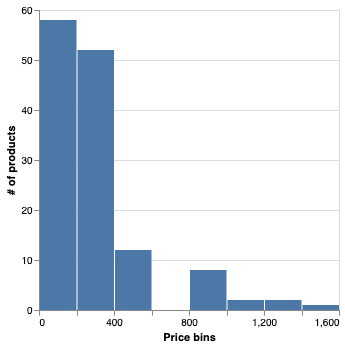

In [7]:
# but looking at the exact distribution gives even more information
alt.Chart(products_df).mark_bar().encode(
    x=alt.X("price:Q", bin=True, title="Price bins"),
    y=alt.Y("count()", title="# of products"),
)

It could make sense to set the space range to 25-1000 so that some outlier values don't distort the space.

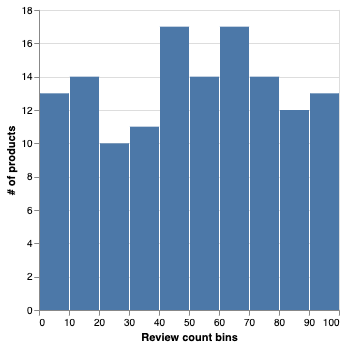

In [8]:
# evenly distributed, so no extra caution needed
alt.Chart(products_df).mark_bar().encode(
    x=alt.X("review_count:Q", bin=True, title="Review count bins"),
    y=alt.Y("count()", title="# of products"),
)

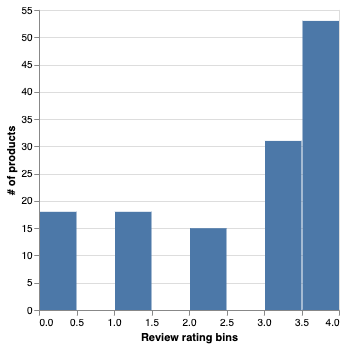

In [9]:
# relatively evenly distributed, I'd still argue for no extra caution needed
alt.Chart(products_df).mark_bar().encode(
    x=alt.X("review_rating:Q", bin=True, title="Review rating bins"),
    y=alt.Y("count()", title="# of products"),
)

## Set up Superlinked

In [10]:
# schema is the way to describe the input data flowing into our system - in a typed manner
@schema
class ProductSchema:
    description: String
    name: String
    category: String
    price: Integer
    review_count: Integer
    review_rating: Integer
    id: IdField


@schema
class UserSchema:
    preference_description: String
    preference_name: String
    preference_category: String
    id: IdField


@event_schema
class EventSchema:
    product: SchemaReference[ProductSchema]
    user: SchemaReference[UserSchema]
    event_type: String
    id: IdField

In [11]:
# we instantiate schemas
product = ProductSchema()
user = UserSchema()
event = EventSchema()

In space definitions we describe how the inputs should be embedded in order to reflect the semantic relationships in our data.

In [12]:
# textual inputs are embedded in a text similarity space powered by a sentence_transformers model
description_space = TextSimilaritySpace(
    text=[user.preference_description, product.description],
    model="sentence-transformers/all-distilroberta-v1",
)
name_space = TextSimilaritySpace(
    text=[user.preference_name, product.name],
    model="sentence-transformers/all-distilroberta-v1",
)
category_space = TextSimilaritySpace(
    text=[user.preference_category, product.category],
    model="sentence-transformers/all-distilroberta-v1",
)

# NumberSpaces encode numeric input in special ways to reflect a relationship
# here we express relationships to price (lower the better), or ratings and review counts (more/higher the better)
price_space = NumberSpace(
    number=product.price, mode=Mode.MINIMUM, min_value=25, max_value=1000
)
review_count_space = NumberSpace(
    number=product.review_count, mode=Mode.MAXIMUM, min_value=0, max_value=100
)
review_rating_space = NumberSpace(
    number=product.review_rating, mode=Mode.MAXIMUM, min_value=0, max_value=4
)

In [13]:
# create the index using the defined spaces
product_index = Index(
    spaces=[
        description_space,
        name_space,
        category_space,
        price_space,
        review_count_space,
        review_rating_space,
    ]
)

In [14]:
# parse our data into the schemas - not matching column names can be conformed to schemas using the mapping parameter
product_df_parser = DataFrameParser(schema=product)
user_df_parser = DataFrameParser(
    schema=user, mapping={user.preference_description: "preference_desc"}
)

In [15]:
# setup our application
source_product: InMemorySource = InMemorySource(product, parser=product_df_parser)
source_user: InMemorySource = InMemorySource(user, parser=user_df_parser)
executor: InMemoryExecutor = InMemoryExecutor(
    sources=[source_product, source_user], indices=[product_index]
)
app: InMemoryApp = executor.run()

In [16]:
# load the actual data into our system
source_product.put([products_df])
source_user.put([user_df])

## Queries

Let's first showcase what we can do without events. We can consider this the cold-start solution.

In [17]:
# let's first define a user query that just searches with the user's preference vector
# configuration options are the imporatances (weights) of each input type (space)
user_query = (
    Query(
        product_index,
        weights={
            description_space: Param("description_weight"),
            name_space: Param("name_weight"),
            category_space: Param("category_weight"),
            price_space: Param("price_weight"),
            review_count_space: Param("review_count_weight"),
            review_rating_space: Param("review_rating_weight"),
        },
    )
    .find(product)
    .with_vector(user, Param("user_id"))
    .limit(TOP_N)
)

In [18]:
def parse_result(result: Result) -> pd.DataFrame:
    """A quick helper to best showcase results"""
    return pd.DataFrame([entry.stored_object for entry in result.entries])

In [19]:
# simple recommendations for our user_1
# these are only based on the initial product the user chose when first entering our site
result = app.query(
    user_query,
    user_id="user_1",
    description_weight=1,
    name_weight=1,
    category_weight=1,
    price_weight=1,
    review_count_weight=1,
    review_rating_weight=1,
)

simple_result = parse_result(result)
simple_result

,description,name,category,price,review_count,review_rating,id
0,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is classic and...",DKNY – Bucket bag,Women Bags,372,91,4,38
1,"With this bag DKNY is keeping real to it’s elegance based-on esthetics. The bag in light grey vintage leather with detachable, adjustable shoulder strap and double top handles offers different car...",DKNY – Bag,Women Bags Shoulder bags,372,94,4,20
2,With this wallet DKNY shows the extravagant part of the label. The many practical pockets provide enough space for cash and cards. The multicolored wallet in leather in snake look is the perfect a...,DKNY – Wallet,Women Bags Wallets,81,68,4,109
3,"This trendy bag from DKNY offers an optimal protection for your laptop. In the rugged leather bag in crocodile look is enough space for everything you need, from the USB stick on the charger to th...",DKNY – Laptop bag,Accessories Women,265,70,4,100
4,The handbag from the label DKNY will add statement to any look. The small zip compartment and the two lateral compartments with many practical internal pockets offer enough space for woman’s most ...,DKNY – Handbag,Women Bags Handbag,456,5,4,315
5,"Its sleek design makes the leather bag from Michael Kors the perfect Everyday- Bag, which offers enough space for the most important essentials in the office, while traveling or shopping. The long...",Michael Kors – Handbag “Jet Set Travel”,Women Bags Handbag,312,97,3,336
6,This bag is a true key piece! The opulent golden LOVE logo on black leather optic add a typical Moschino finish to the bag. The quilted sides in nappa leather add sophistication to the bag.,Moschino Love – Shoulder bag,Women Bags Shoulder bags,227,85,4,56
7,"High-quality and particularly creative handtaschens by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy moldable in...",Gabs – Bag “Sofia”,Women Bags Shoulder bags,210,89,3,370
8,"High-quality and particularly creative handbags by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy moldable in thr...",Gabs – Bag “G3”,Women Bags Handbag,172,63,4,133
9,"Backpacks are celebrating their come back this season! With this trend piece from Guess you’ll be trendy at school, uni or the office. The eye catcher in black leather optic with studs is also the...",Guess – Backpack “Marrakech“,Women Bags,186,70,2,807


In [20]:
# we can also just give the user products that generally seem appealing
# low price, and a lot of good reviews (we can play around with the weights to tune those relationships, too)
result = app.query(
    user_query,
    user_id="user_1",
    description_weight=0,
    name_weight=0,
    category_weight=0,
    price_weight=1,
    review_count_weight=1,
    review_rating_weight=1,
)

general_result = parse_result(result)
general_result

,description,name,category,price,review_count,review_rating,id
0,The zip-around wallet “Langley“ isn’t only a very useful accessory with the studded details it’s also very trendy. The many practical pockets provide enough space for cash and cards. The detachabl...,Guess – Wallet “Langley“,Women Bags Wallets,73,91,4,39
1,"These vests by Italian designer Daniele Alessandrini are edgy, cool and just perfect! The woolen suit vests in gray shades upgrade casual and office looks instantly.",Daniele Alessandrini – Vest,Men Clothing Jackets,165,91,4,36
2,This bag is a true key piece! The opulent golden LOVE logo on black leather optic add a typical Moschino finish to the bag. The quilted sides in nappa leather add sophistication to the bag.,Moschino Love – Shoulder bag,Women Bags Shoulder bags,227,85,4,56
3,"The golden beauty bag from GUM by Gianni Chiarini Design is made out of 100% synthetic gum, so the little bag beard every scent. It is very practical and it can be stowed in a lot. With the trendy...",GUM – Beauty bag,Accessories Women,48,89,3,369
4,With this wallet DKNY shows the extravagant part of the label. The many practical pockets provide enough space for cash and cards. The multicolored wallet in leather in snake look is the perfect a...,DKNY – Wallet,Women Bags Wallets,81,68,4,109
5,"Two in one: the shopper ""Audrey"" is perfect for a long business day or a shopping trip, but also for a nice evening, simply remove the small bag outside. The small bag can also be fixed inside the...",Guess – shopper “Audrey”,Women Bags Shopper,161,74,4,88
6,"With this bag DKNY is keeping real to it’s elegance based-on esthetics. The bag in light grey vintage leather with detachable, adjustable shoulder strap and double top handles offers different car...",DKNY – Bag,Women Bags Shoulder bags,372,94,4,20
7,"The wallet “Carnivale“ is more than just an essential accessory. It’s also ultra-trendy. The many practical pockets provide enough space for cash, cards and banknotes.",Guess – Wallet “Carnivale“,Women Bags Wallets,70,62,4,138
8,"The light vests of Save the Duck keep us cozy warm. The slightly shiny surface in dark blue and slim, quilted fit create a cool look! The ultralight material folds into a small bag!",Save the Duck – Vest “Giga”,Men Clothing Jackets,111,65,4,122
9,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is classic and...",DKNY – Bucket bag,Women Bags,372,91,4,38


In [21]:
search_query = (
    user_query.similar(description_space.text, Param("query_text"))
    .similar(name_space.text, Param("query_text"))
    .similar(category_space.text, Param("query_text"))
)

# search results for the same user, who searched for a term generally
result = app.query(
    search_query,
    user_id="user_1",
    query_text="women clothing jackets",
    description_weight=1,
    name_weight=1,
    category_weight=1,
    price_weight=1,
    review_count_weight=1,
    review_rating_weight=1,
)

parse_result(result)

,description,name,category,price,review_count,review_rating,id
0,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is classic and...",DKNY – Bucket bag,Women Bags,372,91,4,38
1,"With this bag DKNY is keeping real to it’s elegance based-on esthetics. The bag in light grey vintage leather with detachable, adjustable shoulder strap and double top handles offers different car...",DKNY – Bag,Women Bags Shoulder bags,372,94,4,20
2,With this wallet DKNY shows the extravagant part of the label. The many practical pockets provide enough space for cash and cards. The multicolored wallet in leather in snake look is the perfect a...,DKNY – Wallet,Women Bags Wallets,81,68,4,109
3,"This trendy bag from DKNY offers an optimal protection for your laptop. In the rugged leather bag in crocodile look is enough space for everything you need, from the USB stick on the charger to th...",DKNY – Laptop bag,Accessories Women,265,70,4,100
4,"Thanks to their perfect tailoring, leather jackets by Bully are a favorite choice, not only for fashion insiders. Softest leather and modern manufacturing techniques create investment pieces that ...",Bully – Leather Jacket,Women Clothing Jackets,448,96,4,9
5,"Its sleek design makes the leather bag from Michael Kors the perfect Everyday- Bag, which offers enough space for the most important essentials in the office, while traveling or shopping. The long...",Michael Kors – Handbag “Jet Set Travel”,Women Bags Handbag,312,97,3,336
6,The zip-around wallet “Langley“ isn’t only a very useful accessory with the studded details it’s also very trendy. The many practical pockets provide enough space for cash and cards. The detachabl...,Guess – Wallet “Langley“,Women Bags Wallets,73,91,4,39
7,"High-quality and particularly creative handtaschens by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy moldable in...",Gabs – Bag “Sofia”,Women Bags Shoulder bags,210,89,3,370
8,This bag is a true key piece! The opulent golden LOVE logo on black leather optic add a typical Moschino finish to the bag. The quilted sides in nappa leather add sophistication to the bag.,Moschino Love – Shoulder bag,Women Bags Shoulder bags,227,85,4,56
9,"High-quality and particularly creative handbags by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy moldable in thr...",Gabs – Bag “G3”,Women Bags Handbag,172,63,4,133


In [22]:
# giving additional weight to the category space makes more women jackets category product appear
result = app.query(
    search_query,
    user_id="user_1",
    query_text="women clothing jackets",
    description_weight=1,
    name_weight=1,
    category_weight=10,
    price_weight=1,
    review_count_weight=1,
    review_rating_weight=1,
)

parse_result(result)

,description,name,category,price,review_count,review_rating,id
0,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is classic and...",DKNY – Bucket bag,Women Bags,372,91,4,38
1,"Backpacks are celebrating their come back this season! With this trend piece from Guess you’ll be trendy at school, uni or the office. The eye catcher in black leather optic with studs is also the...",Guess – Backpack “Marrakech“,Women Bags,186,70,2,807
2,"The cropped jacket in fur optic of Elisabetta Franchi exudes luxurious glam with cool sophistication. The warm lining and double button closure guarantees coziness, while the cropped sleeves add m...",Elisabetta Franchi – Fur Jacket,Women Clothing Jackets,306,65,1,1176
3,"The down coat by Herno completes our outfits with its matt, sleek optic. The ultralight material makes it foldable and our favorite choice for the winter.",Herno – Down Coat,Women Clothing Jackets,812,29,3,591
4,The handbag from the label DKNY will add statement to any look. The small zip compartment and the two lateral compartments with many practical internal pockets offer enough space for woman’s most ...,DKNY – Handbag,Women Bags Handbag,456,5,4,315
5,This Down Coat by the Italian label Moncler feels like a warm hug and doesn’t only protect you from icy temperatures but is also a cult piece with its slim fit and cozy fur insert on the hood!,Moncler – Down Coat “Fabrefox”,Women Clothing Jackets,1493,39,2,916
6,"High-quality and particularly creative Bags by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. The inner bag is removable.",Gabs – Bag “Lady”,Women Bags Handbag,260,55,3,503
7,"High-quality and particularly creative handbags by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy moldable into t...",Gabs – Bag “Debbie Lux”,Women Bags Handbag,247,63,1,1183
8,The Down Jackets from Moncler are a reason to look forward to winter! “Brady” convinces us with its modern cut and shining material. Ultra stylish!,Moncler – Down jacket “Bady”,Women Clothing Jackets,868,88,1,1107
9,"The down jacket by Herno completes our outfits with its quilted, shiny optic. The ultralight material makes it foldable and our favorite choice for the winter.",Herno – Down Jacket,Women Clothing Jackets,556,96,3,339


In [23]:
# let's bias towards the top-rated products - low rated products disappear, jeans and top rated products are in the top recommendations.
# and also handbags, as user_1 has chosen a handbag when prompted for the first time
# Blending together different aspects!
result = app.query(
    search_query,
    user_id="user_1",
    query_text="women clothing jackets",
    description_weight=0,
    category_weight=10,
    name_weight=0,
    price_weight=1,
    review_count_weight=1,
    review_rating_weight=5,
)

parse_result(result)

,description,name,category,price,review_count,review_rating,id
0,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is classic and...",DKNY – Bucket bag,Women Bags,372,91,4,38
1,The Down Jackets from Moncler are a reason to look forward to winter! “Anet” convinces us with its modern cut and shining material. Ultra stylish!,Moncler – Down jacket “Anet”,Women Clothing Jackets,943,42,4,195
2,The Italian label Moncler presents modern elegant Down Coat with ultimate cult status! This model keeps you cozy and warm throughout the winter. The slightly diagonal zipper and stand-up collar ar...,Moncler – Down Coat “Joinville”,Women Clothing Jackets,1243,22,4,262
3,The Down Jackets from Moncler are a reason to look forward to winter! “Chantilly” convinces us with its modern cut and shining material. Ultra stylish!,Moncler – Down Jacket “Chantilly”,Women Clothing Jackets,1062,17,4,279
4,The handbag from the label DKNY will add statement to any look. The small zip compartment and the two lateral compartments with many practical internal pockets offer enough space for woman’s most ...,DKNY – Handbag,Women Bags Handbag,456,5,4,315
5,"The ""Hamilton"" by Michael Kors is true luxury, which is noticeable every day. The clean lines create elegance and understatement. The grey saffiano leather and silver details complete our daily lo...",Michael Kors – Bag “Hamilton”,Women Bags Handbag,343,14,4,292
6,"Guess’s “Escapade” embodies the sleek elegance so typical for this brand. Subtle color contrasts on clear lines and the detachable clutch complete the urban, sophisticated look.",Guess – handtaschen “Escapade“,Women Bags Handbag,181,47,4,180
7,"Thanks to their perfect tailoring, leather jackets by Bully are a favorite choice, not only for fashion insiders. Softest leather and modern manufacturing techniques create investment pieces that ...",Bully – Leather Jacket,Women Clothing Jackets,448,96,4,9
8,The roomy “Privacy” from Guess works an elegant note into any wardrobe. The strong mixture of clear grey leather imitation and dark gray snake leather optic turn this bag into a real trend piece. ...,Guess – Hand bag “Privacy“,Women Bags Handbag,173,56,4,152
9,"High-quality and particularly creative handbags by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy moldable in thr...",Gabs – Bag “G3”,Women Bags Handbag,172,63,4,133


Now fast-forward a month. Our users made some interactions on our platform. User_1 did some more, while user_2 only did some.

Let's now utilize their behavioural data, represented as events and their effects, for our two example users:

- a user interested in casual and leisure products
- a user interested in elegant products for going out and formal work occasions

In [24]:
events_df = (
    pd.read_json(EVENT_DATASET_URL)
    .reset_index()
    .rename(columns={"index": "id"})
    .head(NROWS)
)
events_df = events_df.merge(
    products_df[["id"]], left_on="product", right_on="id", suffixes=("", "r")
).drop("idr", axis=1)

In [25]:
events_df

,id,user,product,event_type
0,0,user_1,276,clicked_on
1,1,user_1,305,buy
2,3,user_1,481,put_to_cart
3,5,user_1,684,clicked_on
4,7,user_1,966,buy
5,8,user_1,1106,clicked_on
6,10,user_1,1450,put_to_cart
7,14,user_2,547,clicked_on
8,16,user_2,665,put_to_cart


In [26]:
# different actions show certain levels of interest
event_weights = {
    "clicked_on": 0.2,
    "buy": 1,
    "put_to_cart": 0.5,
    "removed_from_cart": -0.5,
}

# adjust the setup to events
product_index_with_events = Index(
    spaces=[
        description_space,
        category_space,
        name_space,
        price_space,
        review_count_space,
        review_rating_space,
    ],
    effects=[
        Effect(
            description_space,
            event.user,
            event_weight * event.product,
            event.event_type == event_type,
        )
        for event_type, event_weight in event_weights.items()
    ]
    + [
        Effect(
            category_space,
            event.user,
            event_weight * event.product,
            event.event_type == event_type,
        )
        for event_type, event_weight in event_weights.items()
    ]
    + [
        Effect(
            name_space,
            event.user,
            event_weight * event.product,
            event.event_type == event_type,
        )
        for event_type, event_weight in event_weights.items()
    ],
)
event_df_parser: DataFrameParser = DataFrameParser(schema=event)
source_event: InMemorySource = InMemorySource(schema=event, parser=event_df_parser)
executor_with_events: InMemoryExecutor = InMemoryExecutor(
    sources=[source_product, source_user, source_event],
    indices=[product_index_with_events],
)
app_with_events: InMemoryApp = executor_with_events.run()

In [27]:
# for a new index, all data has to be put into the source again
source_product.put([products_df])
source_user.put([user_df])
source_event.put([events_df])

In [28]:
# a query only searching with the user's vector
# the preferences are now much more personalised thanks to the events
personalised_query = (
    Query(
        product_index_with_events,
        weights={
            description_space: Param("description_weight"),
            category_space: Param("category_weight"),
            name_space: Param("name_weight"),
            price_space: Param("price_weight"),
            review_count_space: Param("review_count_weight"),
            review_rating_space: Param("review_rating_weight"),
        },
    )
    .find(product)
    .with_vector(user, Param("user_id"))
    .limit(TOP_N)
)

In [29]:
# with small weight on the spaces the events affected, we mainly just alter the results below position 4
result = app_with_events.query(
    personalised_query,
    user_id="user_1",
    description_weight=1,
    category_weight=1,
    name_weight=1,
    price_weight=1,
    review_count_weight=1,
    review_rating_weight=1,
)
res = parse_result(result)
res.join(simple_result, lsuffix="", rsuffix="_base")[
    ["description", "id", "description_base", "id_base"]
]

,description,id,description_base,id_base
0,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is classic and...",38,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is classic and...",38
1,"With this bag DKNY is keeping real to it’s elegance based-on esthetics. The bag in light grey vintage leather with detachable, adjustable shoulder strap and double top handles offers different car...",20,"With this bag DKNY is keeping real to it’s elegance based-on esthetics. The bag in light grey vintage leather with detachable, adjustable shoulder strap and double top handles offers different car...",20
2,With this wallet DKNY shows the extravagant part of the label. The many practical pockets provide enough space for cash and cards. The multicolored wallet in leather in snake look is the perfect a...,109,With this wallet DKNY shows the extravagant part of the label. The many practical pockets provide enough space for cash and cards. The multicolored wallet in leather in snake look is the perfect a...,109
3,"This trendy bag from DKNY offers an optimal protection for your laptop. In the rugged leather bag in crocodile look is enough space for everything you need, from the USB stick on the charger to th...",100,"This trendy bag from DKNY offers an optimal protection for your laptop. In the rugged leather bag in crocodile look is enough space for everything you need, from the USB stick on the charger to th...",100
4,"The surly most stylish choice for sweat pants offers the Italian label Moncler. This black pant convinces us with its urban, athletic chic and sleek look. A comfortable and soft power piece!",481,The handbag from the label DKNY will add statement to any look. The small zip compartment and the two lateral compartments with many practical internal pockets offer enough space for woman’s most ...,315
5,This winter hat by with fur pom-pom by Italian trend label Moncler is the ideal choice for cold days in the city and winter resort!,94,"Its sleek design makes the leather bag from Michael Kors the perfect Everyday- Bag, which offers enough space for the most important essentials in the office, while traveling or shopping. The long...",336
6,Philippe Model’s actual runner “Special” hits the spot with its sportive easiness. The interesting mixture of silver smooth leather and grey suede sums up perfectly with glittery details on the ou...,52,This bag is a true key piece! The opulent golden LOVE logo on black leather optic add a typical Moschino finish to the bag. The quilted sides in nappa leather add sophistication to the bag.,56
7,"Its sleek design makes the leather bag from Michael Kors the perfect Everyday- Bag, which offers enough space for the most important essentials in the office, while traveling or shopping. The long...",336,"High-quality and particularly creative handtaschens by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy moldable in...",370
8,The roomy “Privacy” from Guess works an elegant note into any wardrobe. The strong mixture of clear grey leather imitation and dark gray snake leather optic turn this bag into a real trend piece. ...,152,"High-quality and particularly creative handbags by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy moldable in thr...",133
9,This bag is a true key piece! The opulent golden LOVE logo on black leather optic add a typical Moschino finish to the bag. The quilted sides in nappa leather add sophistication to the bag.,56,"Backpacks are celebrating their come back this season! With this trend piece from Guess you’ll be trendy at school, uni or the office. The eye ca

In [30]:
# with larger weight on the the event affected spaces, more totally new items appear in the TOP10
result = app_with_events.query(
    personalised_query,
    user_id="user_1",
    query_text="",
    description_weight=5,
    category_weight=1,
    name_weight=1,
    price_weight=1,
    review_count_weight=1,
    review_rating_weight=1,
)
res_events = parse_result(result)
res_events.join(simple_result, lsuffix="", rsuffix="_base")[
    ["description", "id", "description_base", "id_base"]
]

,description,id,description_base,id_base
0,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is classic and...",38,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is classic and...",38
1,"This sweat jacket by Italian trend label Moncler combines comfort and trendiness with ease. The interaction of quilted material on hood and hem and cotton, create an urban power look.",966,"With this bag DKNY is keeping real to it’s elegance based-on esthetics. The bag in light grey vintage leather with detachable, adjustable shoulder strap and double top handles offers different car...",20
2,"With this bag DKNY is keeping real to it’s elegance based-on esthetics. The bag in light grey vintage leather with detachable, adjustable shoulder strap and double top handles offers different car...",20,With this wallet DKNY shows the extravagant part of the label. The many practical pockets provide enough space for cash and cards. The multicolored wallet in leather in snake look is the perfect a...,109
3,With this wallet DKNY shows the extravagant part of the label. The many practical pockets provide enough space for cash and cards. The multicolored wallet in leather in snake look is the perfect a...,109,"This trendy bag from DKNY offers an optimal protection for your laptop. In the rugged leather bag in crocodile look is enough space for everything you need, from the USB stick on the charger to th...",100
4,"The surly most stylish choice for sweat pants offers the Italian label Moncler. This black pant convinces us with its urban, athletic chic and sleek look. A comfortable and soft power piece!",481,The handbag from the label DKNY will add statement to any look. The small zip compartment and the two lateral compartments with many practical internal pockets offer enough space for woman’s most ...,315
5,The handbag from the label DKNY will add statement to any look. The small zip compartment and the two lateral compartments with many practical internal pockets offer enough space for woman’s most ...,315,"Its sleek design makes the leather bag from Michael Kors the perfect Everyday- Bag, which offers enough space for the most important essentials in the office, while traveling or shopping. The long...",336
6,With this credit card holder DKNY is keeping real to it’s elegance based-on esthetics. He offers four pockets for cards and cash. The new leather processing “Two-Tone” turns your credit card holde...,1615,This bag is a true key piece! The opulent golden LOVE logo on black leather optic add a typical Moschino finish to the bag. The quilted sides in nappa leather add sophistication to the bag.,56
7,The roomy “Privacy” from Guess works an elegant note into any wardrobe. The strong mixture of clear grey leather imitation and dark gray snake leather optic turn this bag into a real trend piece. ...,152,"High-quality and particularly creative handtaschens by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy moldable in...",370
8,"This trendy bag from DKNY offers an optimal protection for your laptop. In the rugged leather bag in crocodile look is enough space for everything you need, from the USB stick on the charger to th...",100,"High-quality and particularly creative handbags by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy moldable in thr...",133
9,"Its sleek design makes the leather bag from Michael Kors the perfect Everyday- Bag, which offers enough space for the most important essentials in the office, while traveling or shopping. The long...",336,"Backpacks are celebrating their come back this season! With this trend piece 

In [31]:
# and we can also bias towards cheaper products
result = app_with_events.query(
    personalised_query,
    user_id="user_1",
    query_text="",
    description_weight=5,
    category_weight=1,
    name_weight=1,
    price_weight=15,
    review_count_weight=1,
    review_rating_weight=1,
)

res_price = parse_result(result)
res_price.join(res_events, lsuffix="_cheaper", rsuffix="_events")[
    ["price_cheaper", "id_cheaper", "price_events", "id_events"]
]

,price_cheaper,id_cheaper,price_events,id_events
0,48,1615,372,38
1,73,1312,443,966
2,93,1005,372,20
3,48,511,81,109
4,106,1434,262,481
5,40,305,456,315
6,25,620,48,1615
7,173,1282,173,152
8,73,226,265,100
9,81,109,312,336
